In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


## Load Data

In [3]:
adata = sc.read_h5ad('/nfs/team292/ja35/guahmich/guahmich_annotation_17012025.h5ad')

In [4]:
bdata = adata.copy()
bdata.layers['counts'] = bdata.X.copy()
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)
del bdata.varm['PCs']

In [7]:
cell_group = 'sccellfie_annotation_17012025'

In [8]:
batch_key = 'sample' # Specify batch_key or leave as None

### Data Visualization

In [12]:
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, adata.obs['leiden'].unique().shape[0]]))

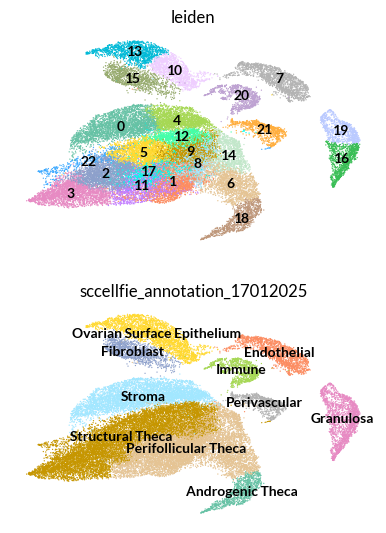

In [22]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(adata,
                color=['leiden', cell_group],
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                legend_loc='on data',
                save='Guahmich-UMAP.pdf'
               )

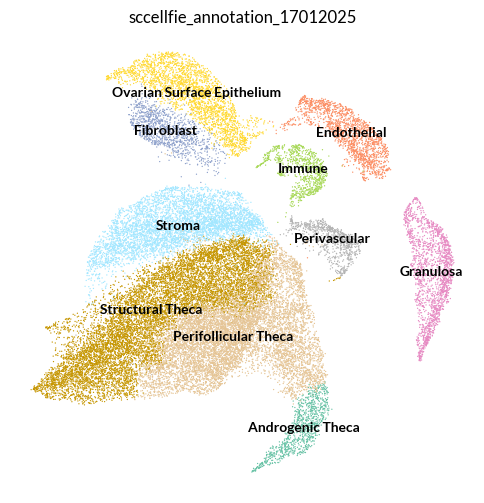

In [27]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 10

sc.pl.embedding(adata,
                color=[cell_group],
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                legend_loc='on data',
                save='Guahmich-reannot-UMAP.pdf'
               )

In [24]:
lit_markers = {'Androgenic Theca' : ['LHCGR', 'CYP11A1'],
               'Endothelial' : ['PECAM1', 'CDH5'],
               'Fibroblast' : ['FAP', 'LUM'],
               'Granulosa' : ['FST', 'AMH'],
               'Immune' : ['HLA-DRA', 'PTPRC'],
               'OSE' : ['KLK11', 'MSLN'],
               'Perifollicular Theca' : ['PTCH1', 'HHIP'],
               'Perivascular' : ['MCAM', 'RGS5'],
               'Stroma' : ['IGFBP3', 'TCF21'],
               'Structural Theca' : ['COL16A1', 'OGN']              
              }

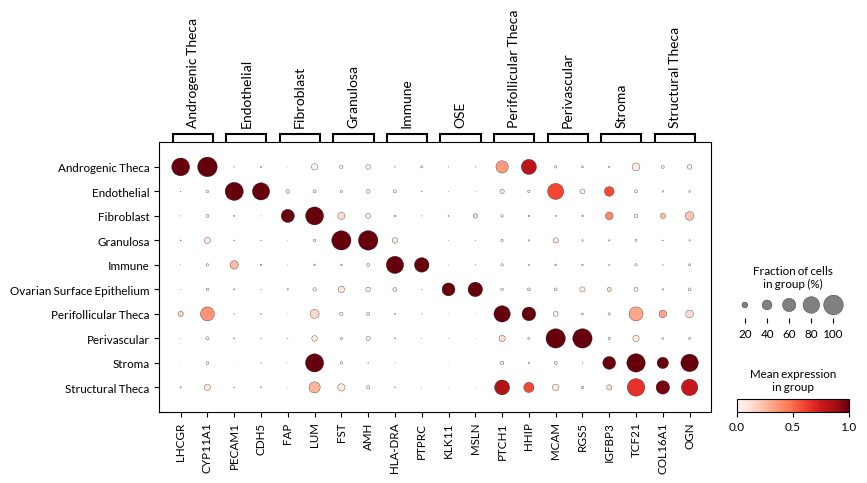

In [25]:
sc.pl.dotplot(bdata,
              lit_markers, 
              groupby=cell_group,
              standard_scale='var',
              save=f'Markers-Cell-Type'
             )

categories: 0, 1, 2, etc.
var_group_labels: Androgenic Theca, Endothelial, Fibroblast, etc.


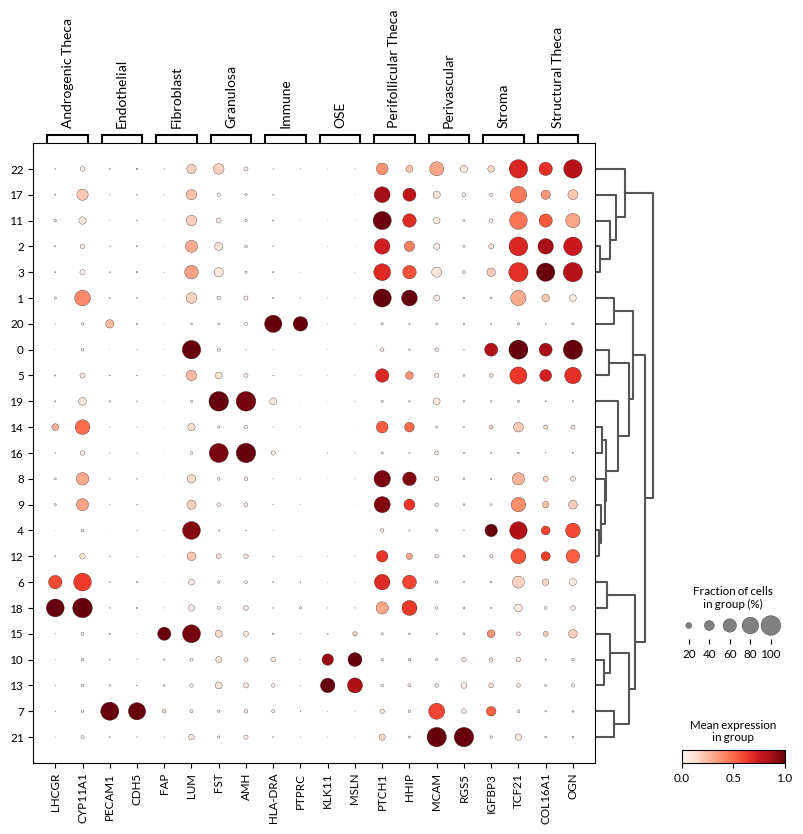

In [26]:
sc.pl.dotplot(bdata,
              lit_markers, 
              groupby='leiden',
              standard_scale='var',
              dendrogram=True,
              save=f'Markers-Leiden'
             )

## Run scCellFie

In [8]:
results = sccellfie.run_sccellfie_pipeline(adata, 
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', 
                                           process_by_group=False, 
                                           groupby=None, 
                                           neighbors_key='neighbors',
                                           n_neighbors=10, 
                                           batch_key=batch_key, 
                                           threshold_key='sccellfie_threshold', 
                                           smooth_cells=True, 
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=False, 
                                           save_folder=None,
                                           save_filename=None
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (34061, 883)
Number of GPRs: 768
Shape of tasks by genes: (217, 883)
Shape of reactions by genes: (768, 883)
Shape of tasks by reactions: (217, 768)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 7/7 [00:54<00:00,  7.79s/it]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 34061/34061 [03:08<00:00, 180.75it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 0 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


In [9]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

## Detection of metabolic task markers & visualization

Detection using TF-IDF

In [13]:
mrks = sccellfie.external.quick_markers(results['adata'].metabolic_tasks,
                                        cluster_key=cell_group, 
                                        n_markers=20, 
                                        express_cut=5*np.log(2))

In [14]:
mrks.head()

,gene,cluster,tf,idf,tf_idf,gene_frequency_outside_cluster,gene_frequency_global,second_best_tf,second_best_cluster,pval,qval
0,Glucose to lactate conversion,Androgenic Theca,0.868339,1.204785,1.046162,0.283319,0.299756,0.598708,Perifollicular Theca,7.273784e-304,0.000000e+00
1,Presence of the thioredoxin system through the...,Androgenic Theca,0.429467,2.155704,0.925804,0.106754,0.115822,0.413233,Ovarian Surface Epithelium,3.713648e-138,0.000000e+00
2,ATP generation from glucose (hypoxic condition...,Androgenic Theca,0.948798,0.902615,0.856400,0.389802,0.405508,0.724179,Perifollicular Theca,2.350441e-292,0.000000e+00
3,AMP salvage from adenine,Androgenic Theca,0.195402,1.959121,0.382817,0.139409,0.140982,0.207431,Perifollicular Theca,1.626603e-06,4.715464e-97
4,Synthesis of inositol,Androgenic Theca,0.174504,1.958496,0.341765,0.140104,0.141070,0.395210,Perivascular,1.914292e-03,0.000000e+00


<Axes: >

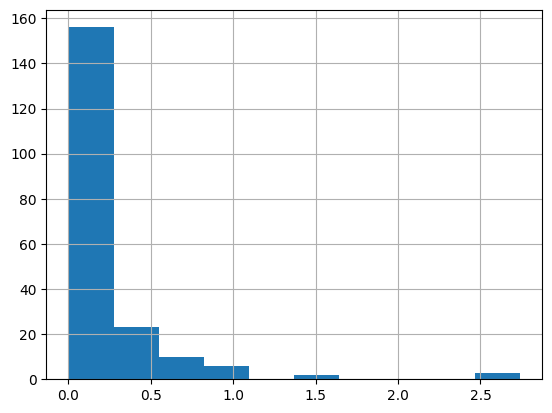

In [15]:
mrks['tf_idf'].hist()

In [16]:
filtered_mrks = mrks[((mrks['tf_idf'] > 0.5) & (mrks['tf']/mrks['second_best_tf'] > 1.5)) | (mrks['tf']/mrks['second_best_tf'] > 10)]

In [18]:
tf_idf_mrks = filtered_mrks['gene'].unique().tolist()

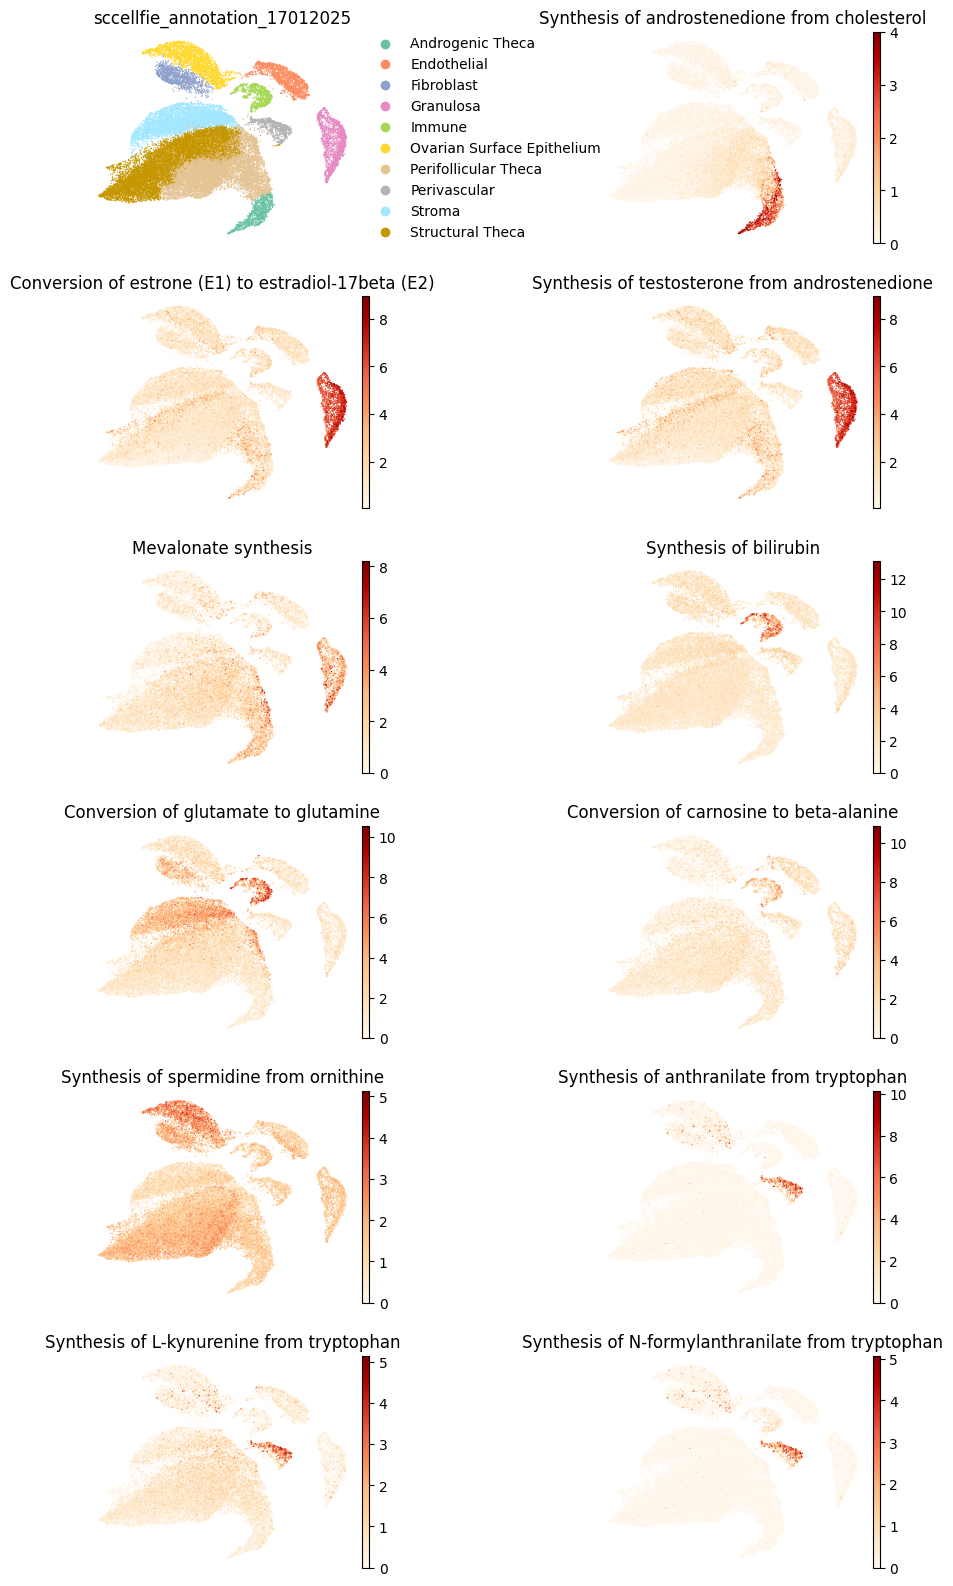

In [19]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + tf_idf_mrks,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd'
               )

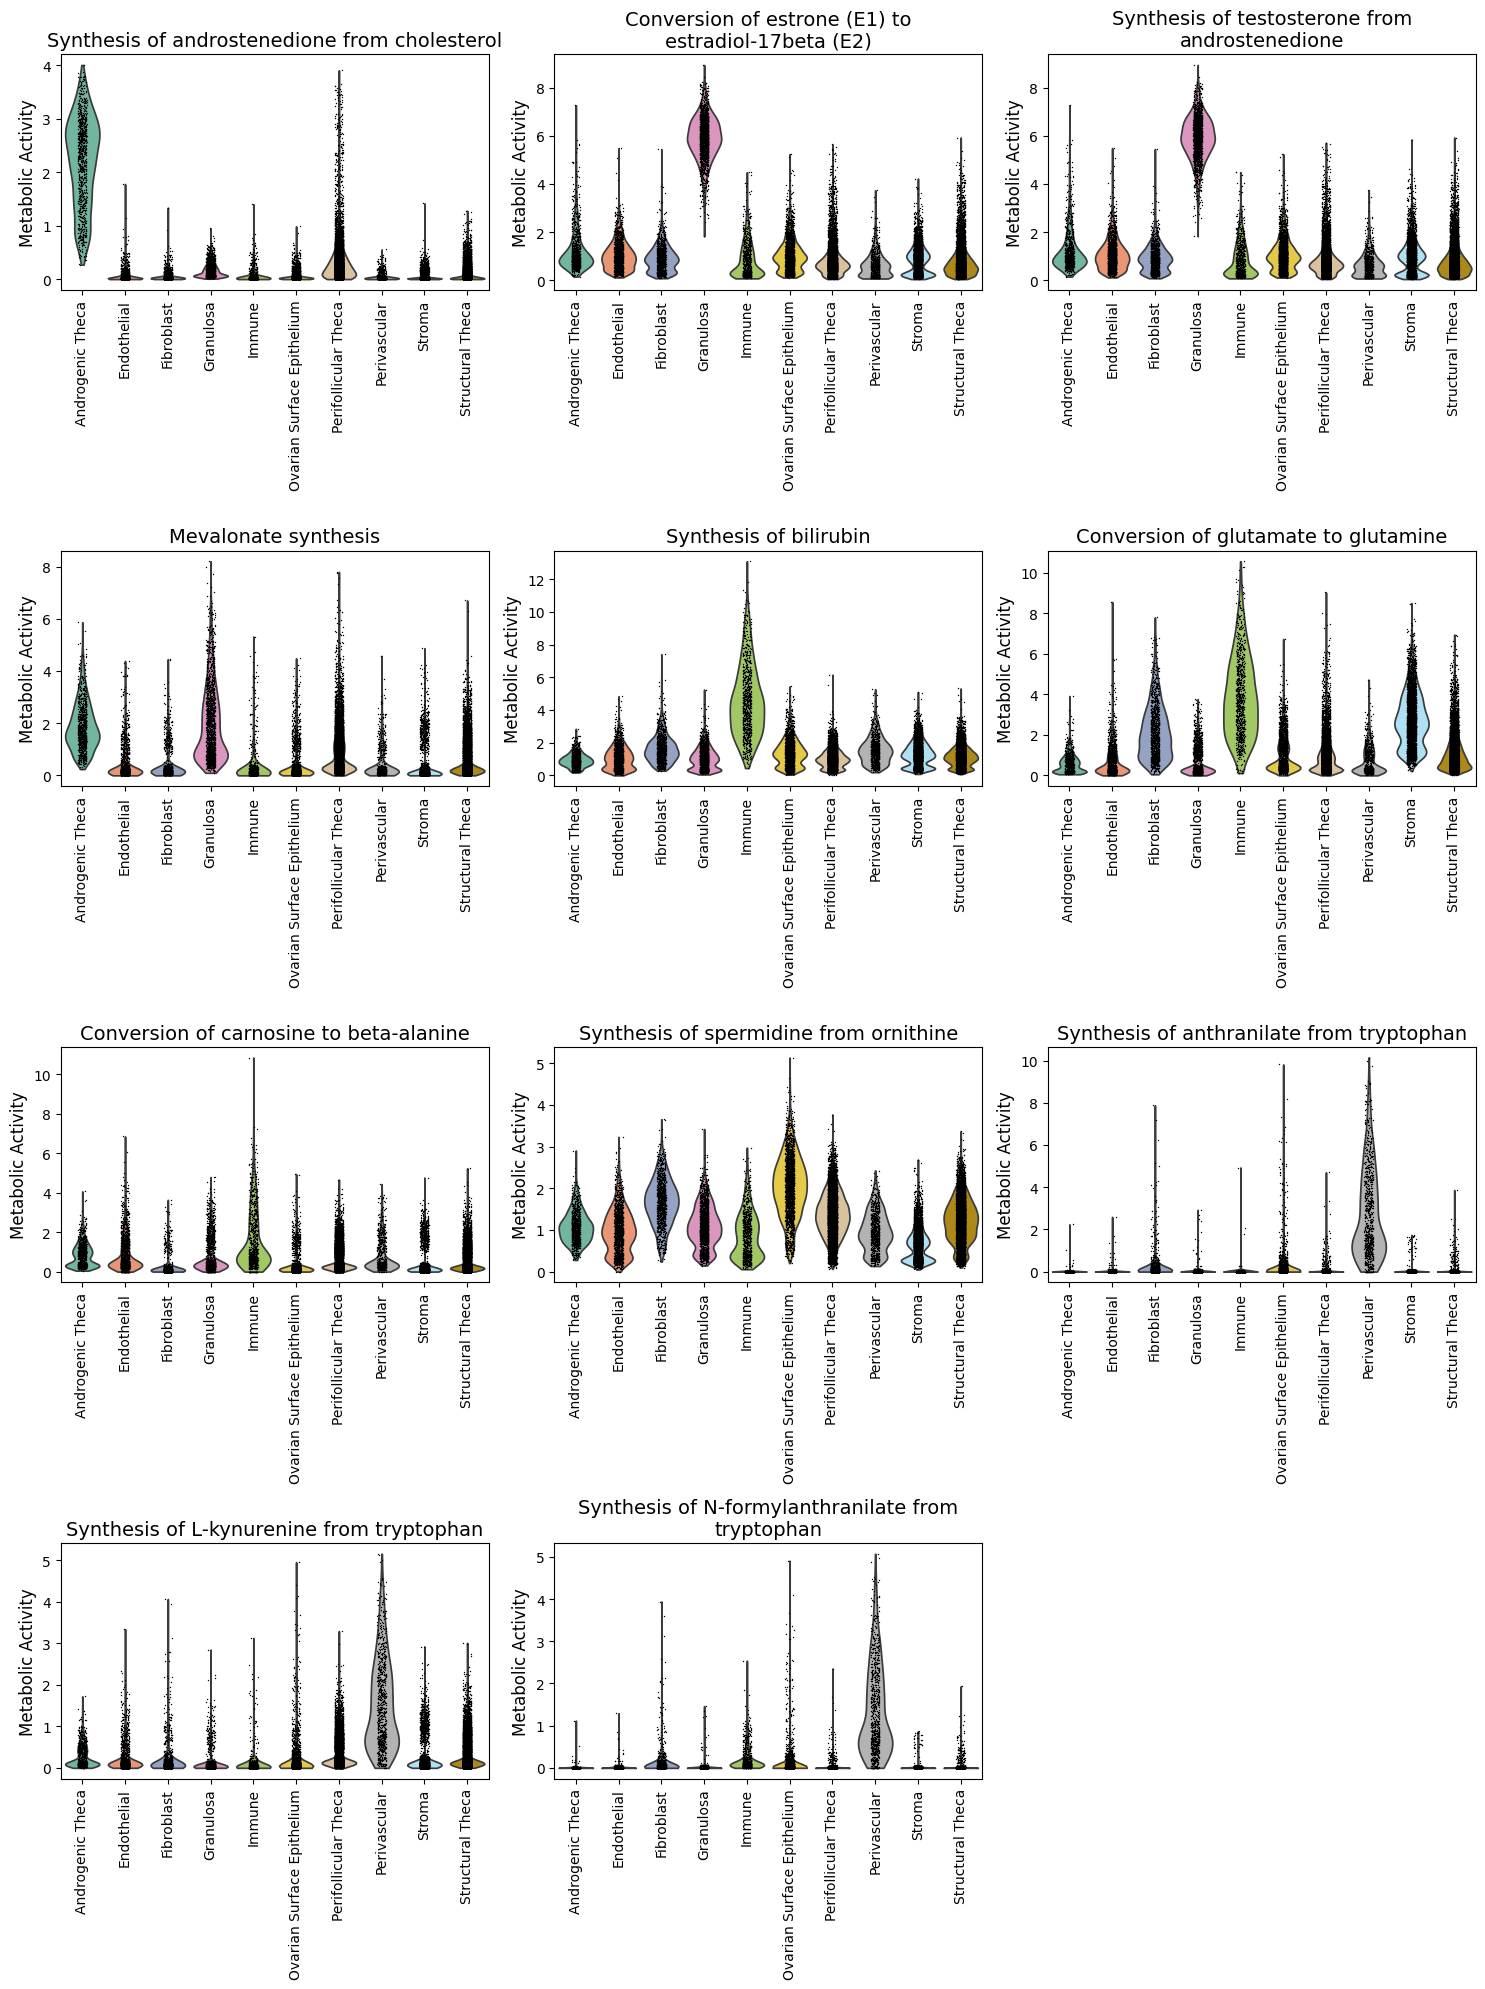

In [27]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=tf_idf_mrks,
                                                         groupby=cell_group,
                                                         n_cols=3,
                                                         ylabel='Metabolic Activity'
                                                        )

Detection using Wilcoxon's test in Scanpy

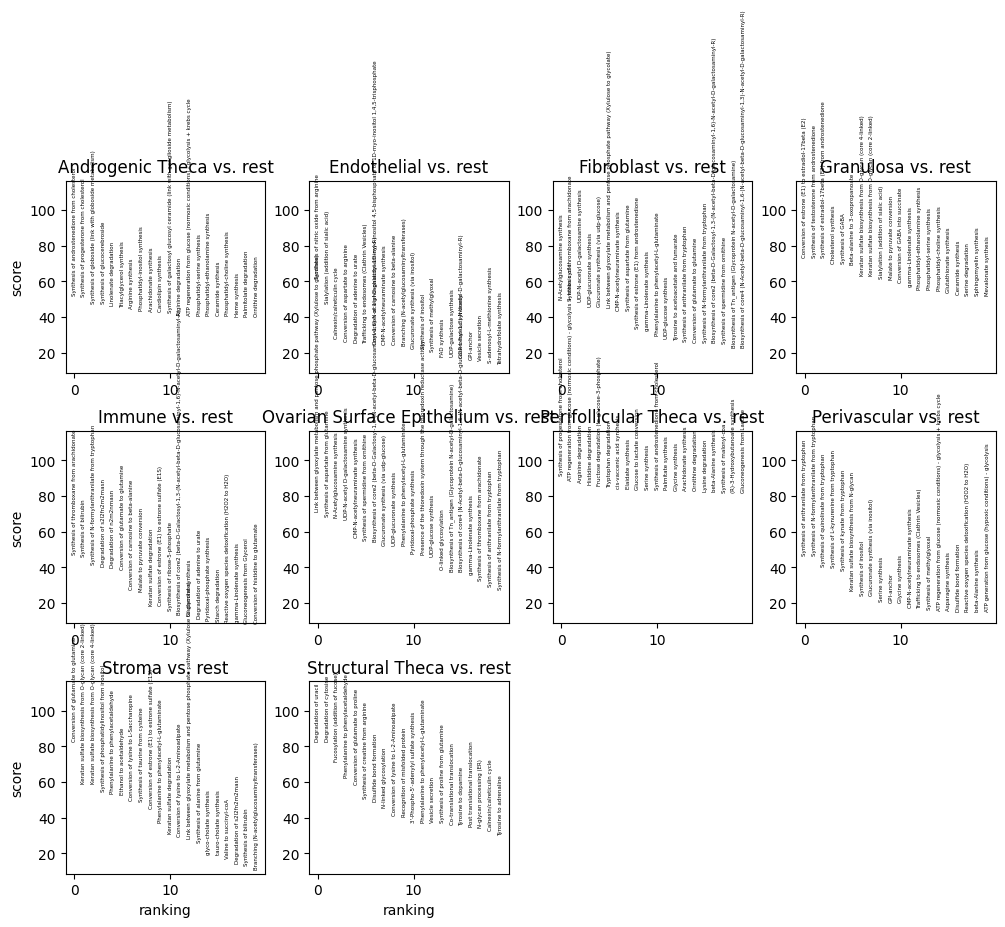

In [24]:
sc.tl.rank_genes_groups(results['adata'].metabolic_tasks, cell_group, method='wilcoxon',
                        use_raw=False, key_added = "wilcoxon")

sc.pl.rank_genes_groups(results['adata'].metabolic_tasks, n_genes=20, sharey=True, key="wilcoxon", fontsize=4)

In [28]:
sc.tl.filter_rank_genes_groups(results['adata'].metabolic_tasks, 
                               key='wilcoxon',
                               min_fold_change=1.5,
                               min_in_group_fraction=0.4,
                               max_out_group_fraction=0.3
                              )

categories: Androgenic Theca, Endothelial, Fibroblast, etc.
var_group_labels: Endothelial, Granulosa, Immune, etc.


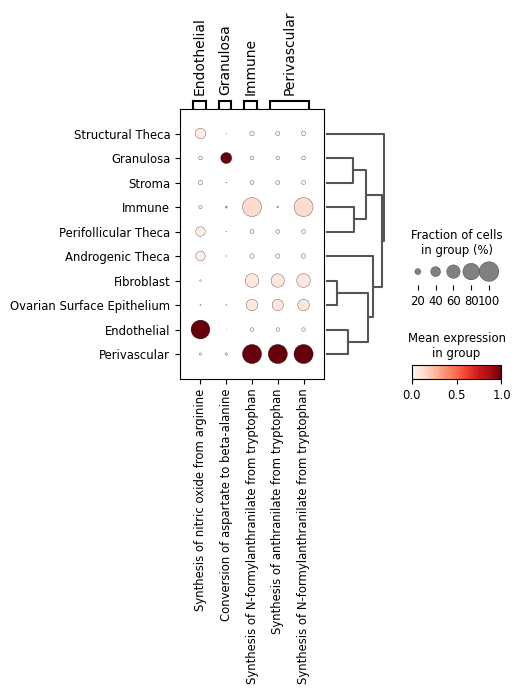

In [29]:
sc.pl.rank_genes_groups_dotplot(results['adata'].metabolic_tasks, n_genes=5, groupby=cell_group, 
                                key='rank_genes_groups_filtered', use_raw=False, standard_scale='var',
                               )

In [30]:
sc_markers_df = sc.get.rank_genes_groups_df(results['adata'].metabolic_tasks, group=None, key='rank_genes_groups_filtered')
sc_markers_df = sc_markers_df.loc[~sc_markers_df['names'].isna()]
scanpy_markers = sc_markers_df['names'].unique().tolist()

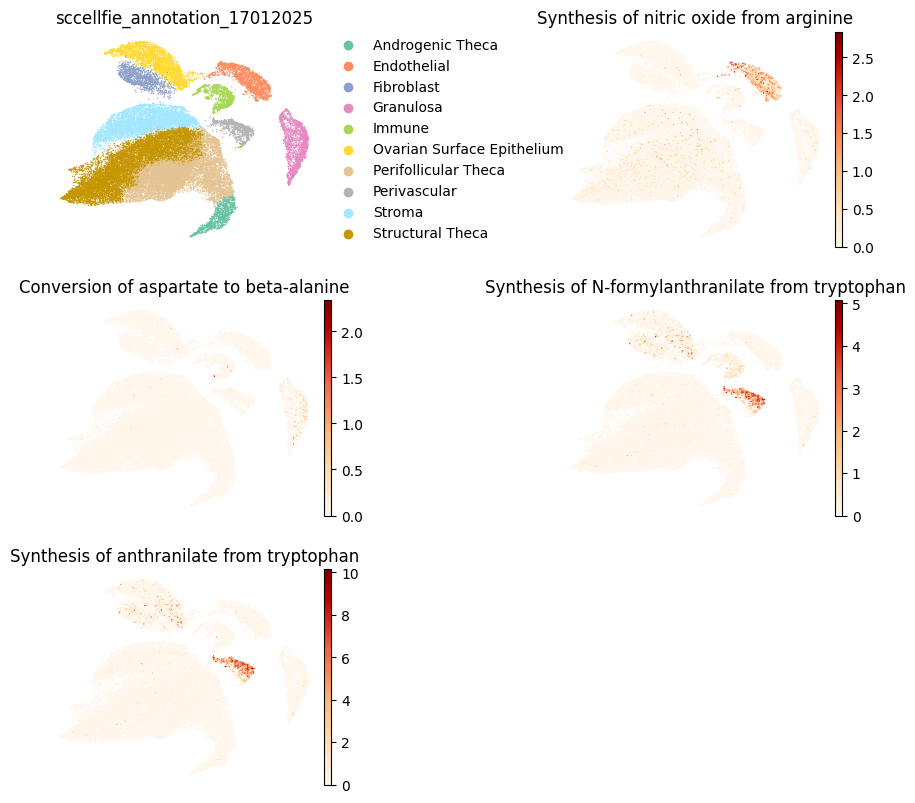

In [31]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + scanpy_markers,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd'
               )

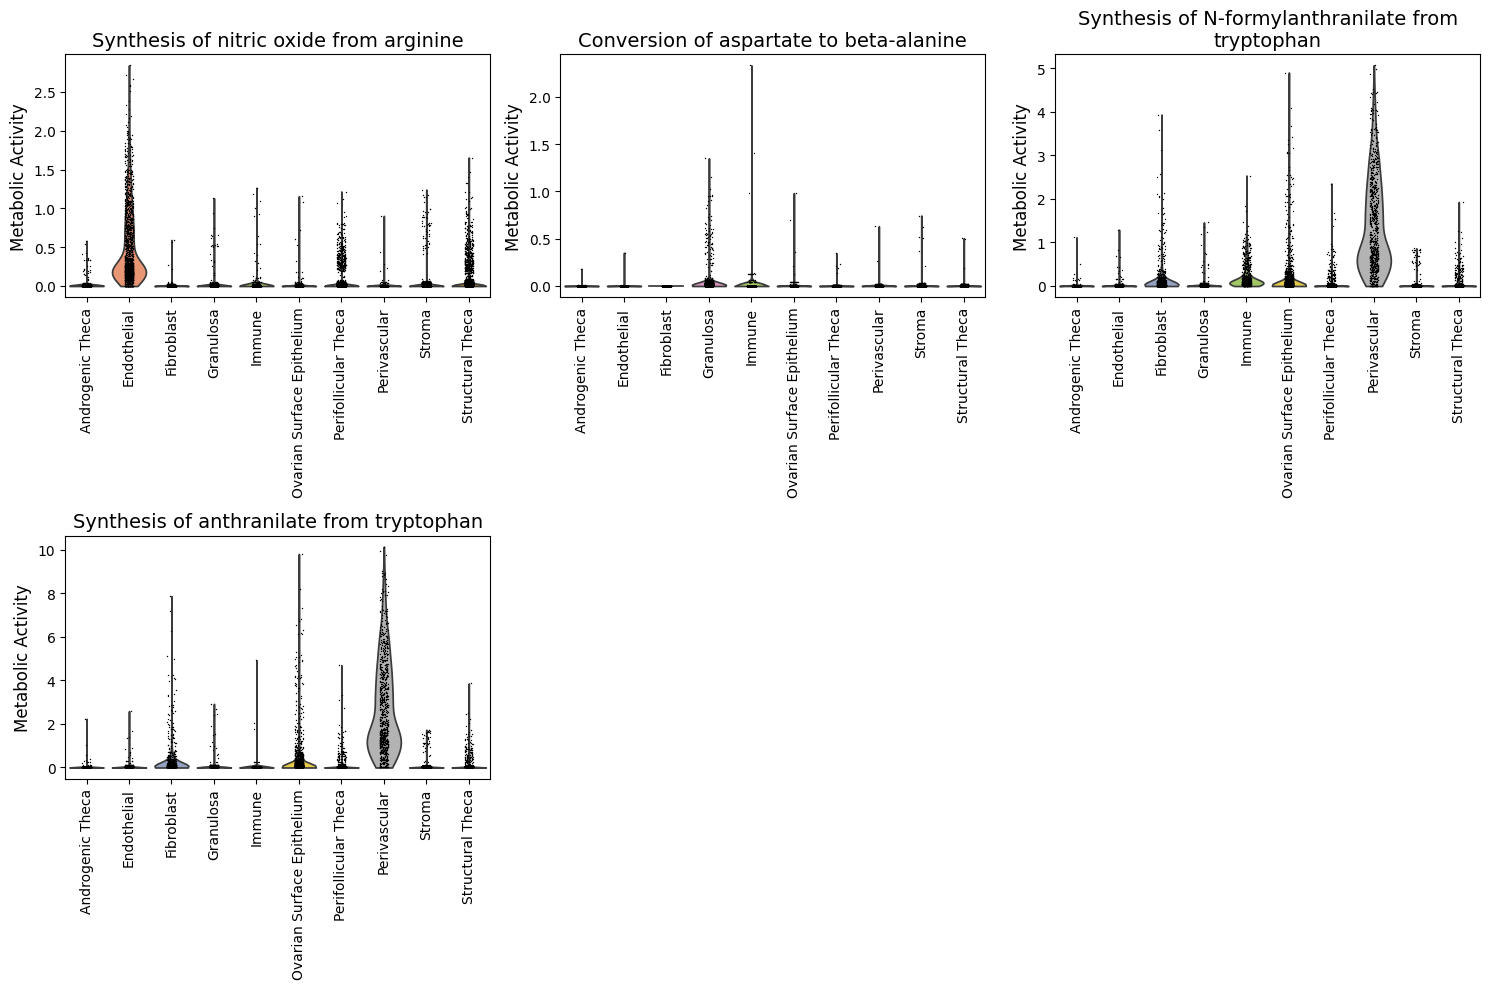

In [32]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=scanpy_markers,
                                                         groupby=cell_group,
                                                         n_cols=3,
                                                         ylabel='Metabolic Activity'
                                                        )

## Visualization of metabolic tasks for sex hormones

In [33]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

In [34]:
results['task_info'].loc[results['task_info']['System'] == 'HORMONES METABOLISM']['Task'].tolist()

['Conversion of estrone (E1) to estradiol-17beta (E2)',
 'Conversion of estrone (E1) to estrone sulfate (E1S)',
 'Synthesis of androstenedione from cholesterol',
 'Synthesis of estradiol-17beta (E2) from androstenedione',
 'Synthesis of estrone (E1) from androstenedione',
 'Synthesis of progesterone from cholesterol',
 'Synthesis of testosterone from androstenedione']

In [35]:
tasks = ['Synthesis of androstenedione from cholesterol',
         'Synthesis of progesterone from cholesterol',
         'Synthesis of estrone (E1) from androstenedione',
         'Conversion of estrone (E1) to estrone sulfate (E1S)',
         'Conversion of estrone (E1) to estradiol-17beta (E2)',
         'Synthesis of testosterone from androstenedione',
         'Synthesis of estradiol-17beta (E2) from androstenedione',
         ]

In [37]:
plt.rcParams['svg.fonttype'] = 'path'

Font name: `Lato`


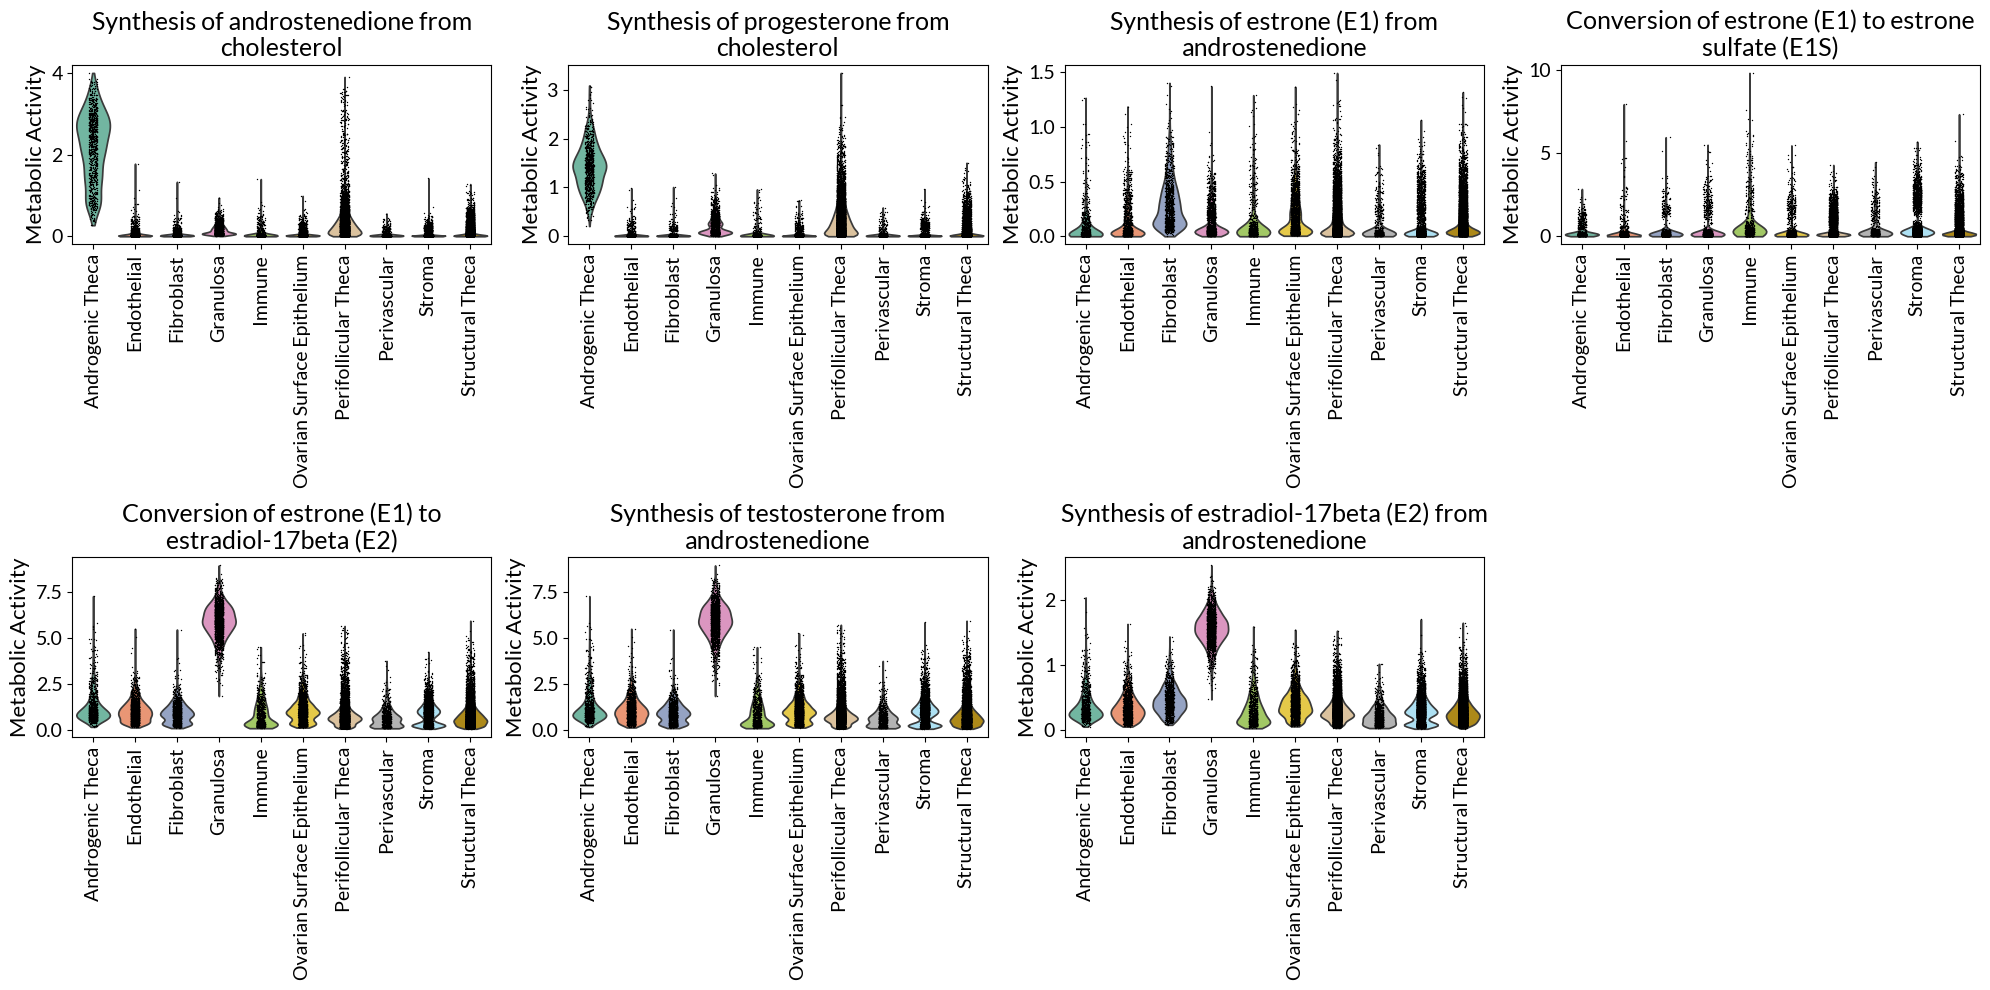

In [48]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=tasks,
                                                         groupby=cell_group,
                                                         n_cols=4,
                                                         save='Guahmich-Hormone-Tasks.svg',
                                                         fontsize=14,
                                                         wrapped_title_length=40,
                                                         ylabel='Metabolic Activity'
                                                        )

## Cell-Cell Communication

In [10]:
adata_updated = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=bdata,
    adata_source=results['adata'].metabolic_tasks,
    var_names=results['adata'].metabolic_tasks.var_names
)

In [11]:
lr_pairs = [('Synthesis of estradiol-17beta (E2) from androstenedione', 'ESR1'),
            ('Synthesis of L-kynurenine from tryptophan', 'AHR')
           ]

In [12]:
ccc = sccellfie.communication.compute_communication_scores(adata_updated, groupby=cell_group, var_pairs=lr_pairs, communication_score='gmean', agg_func='mean',
                               layer=None, ligand_threshold=np.log(2), receptor_threshold=0)

In [13]:
ccc.sort_values('score', ascending=False).head(10)

,sender_celltype,receiver_celltype,ligand,receptor,score,ligand_fraction,receptor_fraction
145,Perivascular,Fibroblast,Synthesis of L-kynurenine from tryptophan,AHR,0.763368,0.725749,0.387611
149,Perivascular,Immune,Synthesis of L-kynurenine from tryptophan,AHR,0.733224,0.725749,0.284051
143,Perivascular,Endothelial,Synthesis of L-kynurenine from tryptophan,AHR,0.726104,0.725749,0.393865
66,Granulosa,Granulosa,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.566182,0.997907,0.234432
151,Perivascular,Ovarian Surface Epithelium,Synthesis of L-kynurenine from tryptophan,AHR,0.558866,0.725749,0.216323
157,Perivascular,Stroma,Synthesis of L-kynurenine from tryptophan,AHR,0.388467,0.725749,0.098000
125,Perifollicular Theca,Fibroblast,Synthesis of L-kynurenine from tryptophan,AHR,0.360893,0.165967,0.387611
78,Granulosa,Structural Theca,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.347935,0.997907,0.133031
129,Perifollicular Theca,Immune,Synthesis of L-kynurenine from tryptophan,AHR,0.346642,0.165967,0.284051
123,Perifollicular Theca,Endothelial,Synthesis of L-kynurenine from tryptophan,AHR,0.343276,0.165967,0.393865


In [22]:
ccc.sort_values('score', ascending=False).loc[ccc.sender_celltype == 'Granulosa']

,sender_celltype,receiver_celltype,ligand,receptor,score,ligand_fraction,receptor_fraction
66,Granulosa,Granulosa,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.566182,0.997907,0.234432
78,Granulosa,Structural Theca,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.347935,0.997907,0.133031
76,Granulosa,Stroma,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.321679,0.997907,0.072400
70,Granulosa,Ovarian Surface Epithelium,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.254243,0.997907,0.051109
72,Granulosa,Perifollicular Theca,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.246568,0.997907,0.071082
60,Granulosa,Androgenic Theca,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.207587,0.997907,0.073145
65,Granulosa,Fibroblast,Synthesis of L-kynurenine from tryptophan,AHR,0.204374,0.051805,0.387611
68,Granulosa,Immune,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.196977,0.997907,0.030268
69,Granulosa,Immune,Synthesis of L-kynurenine from tryptophan,AHR,0.196303,0.051805,0.284051
63,Granulosa,Endothelial,Synthesis of L-kynurenine from tryptophan,AHR,0.194397,0.051805,0.393865
